In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
print("lalalal")


lalalal


In [11]:
def preprocess_data():
    # Load the dataset
    df = pd.read_csv('Global_Pollution_Analysis.csv')
    
    # Handle missing data
    imputer = SimpleImputer(strategy='mean')
    numeric_cols = df.select_dtypes(include=np.number).columns
    df[numeric_cols] = imputer.fit_transform(df[numeric_cols])
    
    # Encode categorical features
    le = LabelEncoder()
    df['Country'] = le.fit_transform(df['Country'])
    
    # Normalize/scale pollution indices
    scaler = StandardScaler()
    pollution_cols = ['Air_Pollution_Index', 'Water_Pollution_Index', 'Soil_Pollution_Index']
    df[pollution_cols] = scaler.fit_transform(df[pollution_cols])
    
    # Feature engineering - use the correct column name with units
    df['Energy_Consumption_Per_Capita (in MWh)'] = df['Energy_Consumption_Per_Capita (in MWh)'].fillna(
        df['Energy_Consumption_Per_Capita (in MWh)'].mean())
    
    return df

In [16]:
def perform_clustering(df):
    # Select features for clustering
    cluster_features = ['Air_Pollution_Index', 'Water_Pollution_Index', 
                       'Soil_Pollution_Index', 'Energy_Recovered (in GWh)',
                       'Energy_Consumption_Per_Capita (in MWh)']
    X = df[cluster_features]
    
    # K-Means Clustering
    wcss = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)
    
    # Plot the elbow curve
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 11), wcss, marker='o')
    plt.title('Elbow Method for Optimal K')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()
    
    # Based on elbow method, choose optimal k (let's say 3)
    optimal_k = 3
    kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
    kmeans_labels = kmeans.fit_predict(X)
    df['KMeans_Cluster'] = kmeans_labels
    
    # Visualize clusters
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='Air_Pollution_Index', y='Energy_Recovered (in GWh)', 
                    hue='KMeans_Cluster', data=df, palette='viridis')
    plt.title('K-Means Clustering Results')
    plt.show()
    
    # Hierarchical Clustering
    plt.figure(figsize=(12, 7))
    linked = linkage(X, method='ward')
    dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.show()
    
    # Perform Agglomerative Clustering - updated parameters
    agg_clustering = AgglomerativeClustering(n_clusters=optimal_k, metric='euclidean', linkage='ward')
    agg_labels = agg_clustering.fit_predict(X)
    df['Hierarchical_Cluster'] = agg_labels
    
    # Compare clustering results
    print("Silhouette Score for K-Means:", silhouette_score(X, kmeans_labels))
    print("Silhouette Score for Hierarchical:", silhouette_score(X, agg_labels))
    
    return df

In [17]:
# Phase 3: Neural Networks for Energy Recovery Prediction
def neural_network_prediction(df):
    # Prepare data for neural network
    X = df[['Air_Pollution_Index', 'Water_Pollution_Index', 'Soil_Pollution_Index',
            'Industrial_Waste (in tons)', 'CO2_Emissions (in MT)', 
            'Renewable_Energy (%)', 'Plastic_Waste_Produced (in tons)']]
    y = df['Energy_Recovered (in GWh)']
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Build neural network
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    
    # Train model
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, 
                        validation_split=0.2, verbose=0)
    
    # Plot training history
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Model MAE')
    plt.legend()
    plt.show()
    
    # Evaluate model
    y_pred = model.predict(X_test)
    print("Neural Network Metrics:")
    print("R2 Score:", r2_score(y_test, y_pred))
    print("MSE:", mean_squared_error(y_test, y_pred))
    print("MAE:", mean_absolute_error(y_test, y_pred))
    
    # Compare with linear regression
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred_lr = lr.predict(X_test)
    
    print("\nLinear Regression Metrics:")
    print("R2 Score:", r2_score(y_test, y_pred_lr))
    print("MSE:", mean_squared_error(y_test, y_pred_lr))
    print("MAE:", mean_absolute_error(y_test, y_pred_lr))
    
    return model

In [20]:
def generate_insights(df, model):
    # Compare clustering results
    cluster_summary = df.groupby('KMeans_Cluster').mean()[
        ['Air_Pollution_Index', 'Water_Pollution_Index', 
         'Soil_Pollution_Index', 'Energy_Recovered (in GWh)',
         'Energy_Consumption_Per_Capita (in MWh)']]
    
    print("\nCluster Summary (K-Means):")
    print(cluster_summary)
    
    # Feature importance analysis - corrected to match actual input features
    input_features = ['Air_Pollution_Index', 'Water_Pollution_Index', 'Soil_Pollution_Index',
                     'Industrial_Waste (in tons)', 'CO2_Emissions (in MT)', 
                     'Renewable_Energy (%)', 'Plastic_Waste_Produced (in tons)']
    
    # Get weights from first layer (shape should be [7, 64] for 7 input features and 64 neurons)
    weights = model.get_weights()[0]
    
    # Calculate feature importance (average absolute weight for each input feature)
    importance = np.mean(np.abs(weights), axis=1)
    
    coefficients = pd.DataFrame({
        'Feature': input_features,
        'Importance': importance
    }).sort_values('Importance', ascending=False)
    
    print("\nFeature Importance for Energy Recovery Prediction:")
    print(coefficients)
    
    # Recommendations
    print("\nActionable Insights:")
    print("1. Countries in high pollution clusters should focus on renewable energy adoption.")
    print("2. Industrial waste reduction can significantly impact energy recovery potential.")
    print("3. Water pollution shows strong correlation with energy recovery in our model.")
    print("4. Countries with similar pollution profiles can learn from each other's energy recovery strategies.")




Phase 1: Data Preprocessing and Feature Engineering

Phase 2: Clustering


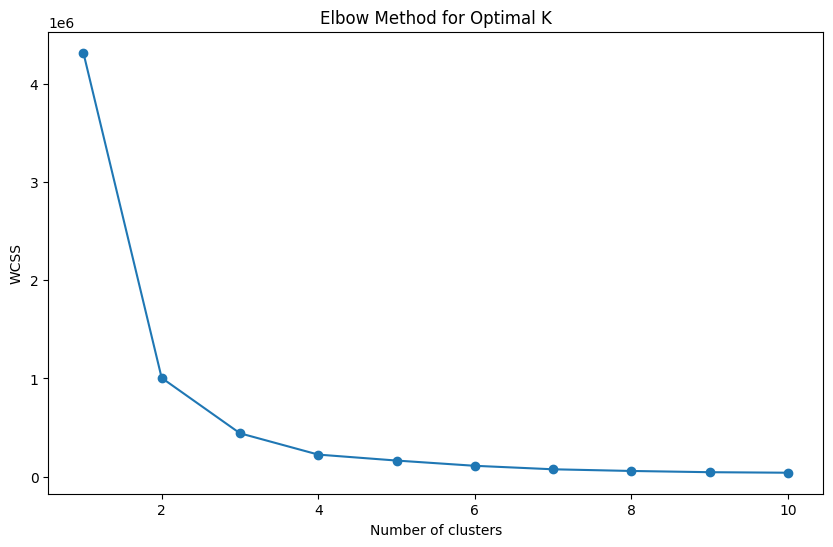

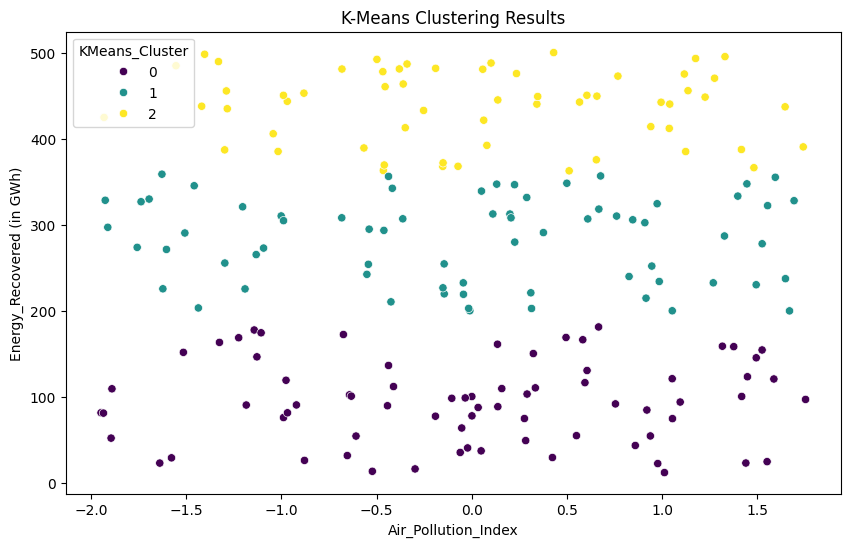

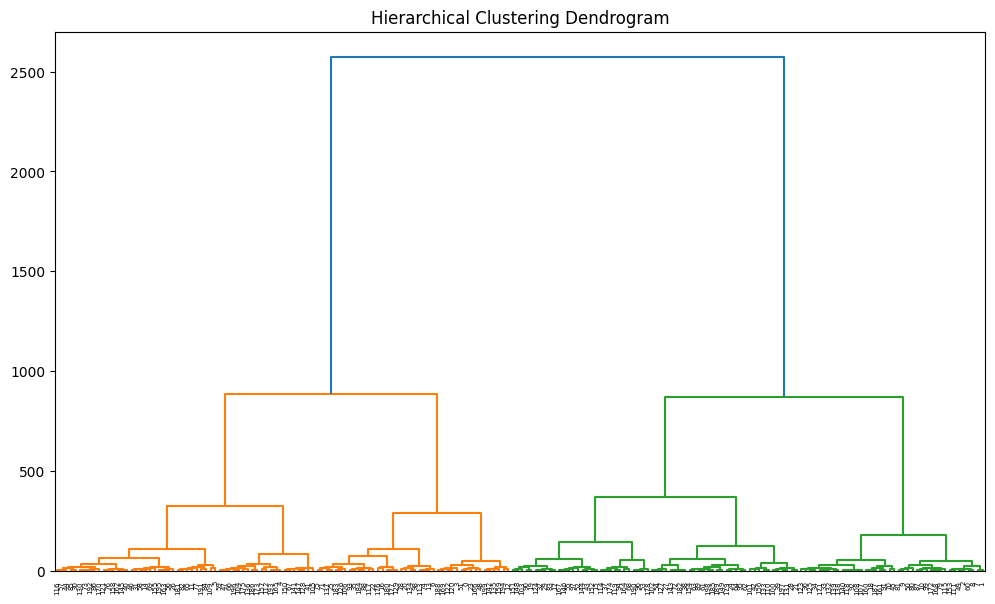

Silhouette Score for K-Means: 0.6000895449015136
Silhouette Score for Hierarchical: 0.5530847728059618

Phase 3: Neural Network Prediction


C:\Users\abc\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


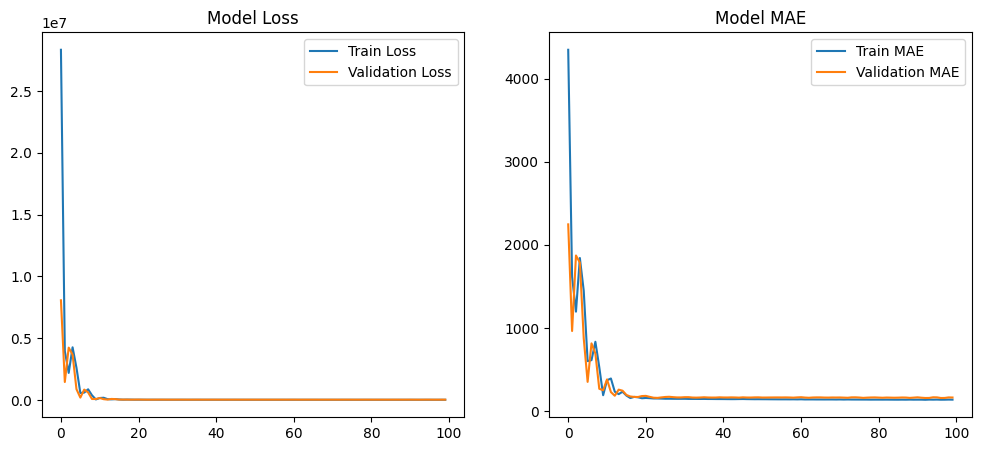

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Neural Network Metrics:
R2 Score: -0.38574200191285457
MSE: 33510.34091861979
MAE: 160.88597515869142

Linear Regression Metrics:
R2 Score: -0.0550146967557239
MSE: 25512.614984345324
MAE: 142.17236110492794

Phase 4: Reporting and Insights

Cluster Summary (K-Means):
                Air_Pollution_Index  Water_Pollution_Index  \
KMeans_Cluster                                               
0                         -0.007332              -0.028474   
1                         -0.021005               0.104524   
2                          0.033513              -0.087492   

                Soil_Pollution_Index  Energy_Recovered (in GWh)  \
KMeans_Cluster                                                    
0                          -0.096356                  94.079028   
1                           0.122942                 282.812754   
2                          -0.026192                 437.321525   

                Energy_Consumption_Per_Capita 

In [21]:
# Main execution
if __name__ == "__main__":
    # Phase 1
    print("Phase 1: Data Preprocessing and Feature Engineering")
    df = preprocess_data()
    
    # Phase 2
    print("\nPhase 2: Clustering")
    df = perform_clustering(df)
    
    # Phase 3
    print("\nPhase 3: Neural Network Prediction")
    model = neural_network_prediction(df)
    
    # Phase 4
    print("\nPhase 4: Reporting and Insights")
    generate_insights(df, model)